In [23]:
%matplotlib inline

import pandas as pd
import numpy as np
import gc
import time

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

sns.set_style('dark')

SEED = 2313
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

%run ../src/data/HotstarDataset.py
%run ../src/features/categorical_features.py
%run ../src/features/util.py
%run ../src/models/cross_validation.py

In [8]:
dataset = Hotstar('../data/raw/5f828822-4--4-hotstar_dataset/')
dataset.load_data('../data/processed/hotstar_processed.feather')

data_processed = dataset.data
train_mask     = dataset.get_train_mask() 

In [9]:
# create ohe feature for genres, tod and dow
genres_ohe = create_from_dict(data_processed, 'genres')
tod_ohe    = create_from_dict(data_processed, 'tod')
dow_ohe    = create_from_dict(data_processed, 'dow')

In [10]:
# count features
data_processed['num_cities'] = count_feature(data_processed.cities)
data_processed['num_genres'] = count_feature(data_processed.genres)
data_processed['num_titles'] = count_feature(data_processed.titles)
data_processed['num_tod']    = count_feature(data_processed.tod)
data_processed['num_dow']    = count_feature(data_processed.dow)

# watch time
data_processed['watch_time_sec'] = num_seconds_watched(data_processed.genres)

In [12]:
data = pd.concat((genres_ohe, tod_ohe, dow_ohe,
                  data_processed.num_cities,
                  data_processed.num_genres,
                  data_processed.num_titles,
                  data_processed.num_tod,
                  data_processed.num_dow,
                  data_processed.watch_time_sec,
                  data_processed.segment
                 ), axis='columns')

In [14]:
save_file(data, '../data/processed/hotstar_processed_exp_8.feather')

In [16]:
f = data.columns.drop('segment')

X = data.loc[train_mask, f]
y = data.loc[train_mask, 'segment']

Xtest = data.loc[~train_mask, f]

In [18]:
params = {
    'stratify': y,
    'test_size': .2,
    'random_state': SEED
}

X_train, X_test, y_train, y_test = get_train_test_split(X, y, **params)

In [20]:
params = {
    'stratify': y_train,
    'test_size': .2,
    'random_state': SEED
}

Xtr, Xte, ytr, yte = get_train_test_split(X_train, y_train, **params)

In [29]:
dtrain = xgb.DMatrix(Xtr, ytr, missing=np.nan, feature_names=f)
dtest  = xgb.DMatrix(Xte, yte, missing=np.nan, feature_names=f)

xgb_params = {
    'eta': 0.008,
    'max_depth': 8,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': .8,
    'objective': 'binary:logistic',
    'seed': SEED,
    'eval_metric': 'auc',
    'verbose': 1,
    'gamma': 1,
    'nthread': 8
}

n_estimators = 500

watchlist = [(dtrain, 'train'), (dtest, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=n_estimators, verbose_eval=10,
                  evals=watchlist
                 )

[0]	train-auc:0.799452	val-auc:0.786533
[10]	train-auc:0.828899	val-auc:0.803547
[20]	train-auc:0.831482	val-auc:0.805615
[30]	train-auc:0.833197	val-auc:0.806399
[40]	train-auc:0.834322	val-auc:0.806988
[50]	train-auc:0.835874	val-auc:0.807425
[60]	train-auc:0.836157	val-auc:0.807444
[70]	train-auc:0.836625	val-auc:0.807631
[80]	train-auc:0.83739	val-auc:0.80752
[90]	train-auc:0.838204	val-auc:0.807834
[100]	train-auc:0.838983	val-auc:0.808035
[110]	train-auc:0.839554	val-auc:0.807998
[120]	train-auc:0.840587	val-auc:0.808072
[130]	train-auc:0.841561	val-auc:0.808265
[140]	train-auc:0.842484	val-auc:0.808335
[150]	train-auc:0.843355	val-auc:0.808319
[160]	train-auc:0.844336	val-auc:0.808515
[170]	train-auc:0.845177	val-auc:0.808469
[180]	train-auc:0.846084	val-auc:0.808348
[190]	train-auc:0.846779	val-auc:0.808274
[200]	train-auc:0.847611	val-auc:0.808347
[210]	train-auc:0.848353	val-auc:0.808354
[220]	train-auc:0.849127	val-auc:0.808558
[230]	train-auc:0.84994	val-auc:0.808652
[240]	

In [31]:
# test on unseen data
dtrain = xgb.DMatrix(X_train, y_train, missing=np.nan, feature_names=f)
dval   = xgb.DMatrix(X_test, y_test, missing=np.nan, feature_names=f)

n_estimators = 550
start = time.time()
model = xgb.train(xgb_params, dtrain, num_boost_round=n_estimators)
end   = time.time()
preds = model.predict(dval)

print('It took: {} seconds to train model'.format(end - start))
print('AUC on test set: {}'.format(roc_auc_score(y_test, preds)))

It took: 262.6242287158966 seconds to train model
AUC on test set: 0.8145467705940561


In [32]:
# train on full data
dtrain = xgb.DMatrix(X, y, missing=np.nan, feature_names=f)
dtest  = xgb.DMatrix(Xtest, missing=np.nan, feature_names=f)

n_estimators = 600
start = time.time()
model = xgb.train(xgb_params, dtrain, num_boost_round=n_estimators)
end  = time.time()

preds = model.predict(dtest)

print('It took: {} seconds to train model'.format(end - start))

It took: 363.9025273323059 seconds to train model


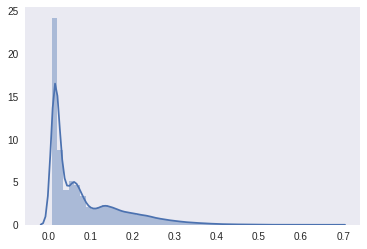

In [33]:
sns.distplot(preds);

In [34]:
sub            = pd.read_csv('../data/raw/5f828822-4--4-hotstar_dataset/sample_submission.csv')
sub['segment'] = preds
sub['ID']      = data_processed.loc[~train_mask, 'ID'].values
sub.to_csv('../submissions/hotstar/xgb_processed_dataset_2.csv', index=False)